# Mining Process – % Silica Concentrate Prediction  

This project aims to develop a **machine learning regression model** to predict the **% Silica Concentrate** in a mining flotation process using operational plant data.  
Accurate prediction of silica concentration is essential to improve process efficiency, reduce laboratory dependency, and support real-time decision-making in the field. The code is divided into three main parts, which are:
1. Data ingestion and preprocessing  
2. Feature selection and treatment  
3. Time-aware train-test split  
4. Model training with early stopping  
5. Performance evaluation and result visualization  


**Responsible:** Paulo Casmal

**Email:** <paulo.casmal@gmail.com>

**Date:** 12-15-2025


---


## 01 - Imports & Configurations

In [39]:
# import necessary libraries
import pandas as pd
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA

In [40]:
# Configuration of matplotlib parameters for consistent styling
mpl.rcParams['figure.figsize'] = (10, 6)  # Default figure size
mpl.rc('lines', lw=2)  # Sets the line width
mpl.rcParams['grid.linewidth'] = 0.5  # Grid line width
mpl.rcParams['grid.linestyle'] = 'dashed'  # Grid line style
mpl.rc(('xtick', 'ytick'), labelsize=15)  # Axis tick label size
mpl.rc('font', family='Times New Roman', size=15)  # Font family and font size
mpl.rcParams['axes.linewidth'] = 0.5 # - Largura das bordas dos gráficos

In [41]:
# Load the dataset
path = r'C:\Users\paulo\Downloads\archive (2)\MiningProcess_Flotation_Plant_Database.csv'

df = pd.read_csv(path, decimal=',')

df.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

## 02 - Dataset treatment

In [ ]:
# Convert 'date' column to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [ ]:
df.columns

Index(['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

Drop the '% Iron Concentrate' column due to high correlation with target variable. Additionaly, this variable can be measured only at laboratory, which not helps to predict the '% Silica Concentrate' in field.

In [ ]:
df = df.drop(columns=['% Iron Concentrate'])

### 02.1 - Adding Time Features

In [ ]:


def create_time_features(df):
    """Create time-based features from datetime index."""
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter

    return df


df = create_time_features(df)

### 02.2 - Cross Validation

In [ ]:
# tss = TimeSeriesSplit(n_splits=5, test_size=3*30*24*30, gap=3*30*24) # 15 days data for testing

# df = df.sort_index()

In [ ]:
# fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

# for fold, (train_index, test_index) in enumerate(tss.split(df)):
#     train = df.iloc[train_index]
#     test = df.iloc[test_index]

#     axs[fold].plot(train.index, train['% Silica Concentrate'], label='Train', color='tab:blue')
#     axs[fold].plot(test.index, test['% Silica Concentrate'], label='Test', color='tab:orange')
#     axs[fold].axvline(x=test.index[0], color='k', linestyle='--', label='Test Start')

#     axs[fold].set_title(f'Fold {fold}')
#     axs[fold].legend()

# plt.xlabel('Date')
# plt.tight_layout()
# plt.show()

### 02.2 - Training by month

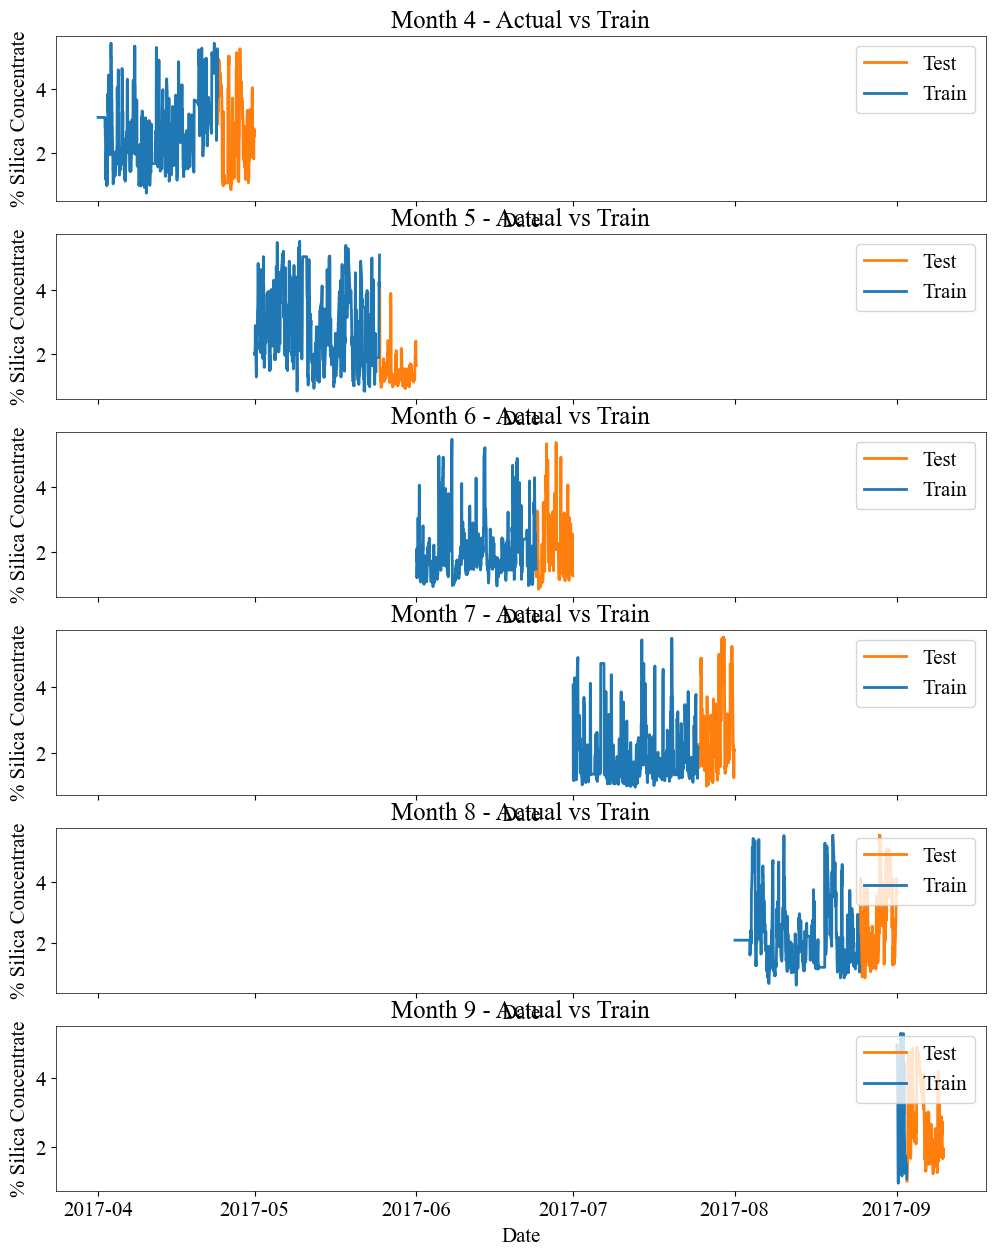

In [ ]:
preds = []
scores = []

fig, ax = plt.subplots(len(df.index.month.unique()) - 1, 1, figsize=(12, 2.5 * (len(df.index.month.unique()) - 1)), sharex=True)

for ind, (month, group) in enumerate(df.groupby(df.index.month)):
    if ind == 0:
        continue  # Skip the first month

    X = group.drop(columns=['% Silica Concentrate'])
    y = group['% Silica Concentrate']

    # Identify the last week of data for testing
    last_week_index = group[group.index >= group.index.max() - pd.Timedelta(days=7)].index

    # Split into training and testing sets
    X_train = X.drop(index=last_week_index)
    y_train = y.drop(index=last_week_index)

    X_test = X.loc[last_week_index]
    y_test = y.loc[last_week_index]

    ax[ind - 1].plot(y_test.index, y_test, label='Test', c='tab:orange')
    ax[ind - 1].plot(y_train.index, y_train, label='Train', c='tab:blue')

    ax[ind - 1].set_title(f'Month {month} - Actual vs Train')
    ax[ind - 1].set_ylabel('% Silica Concentrate')
    ax[ind - 1].legend(loc='upper right')
    
ax[ind - 1].set_xlabel('Date')
plt.show()

### 02.3 StandardScaler

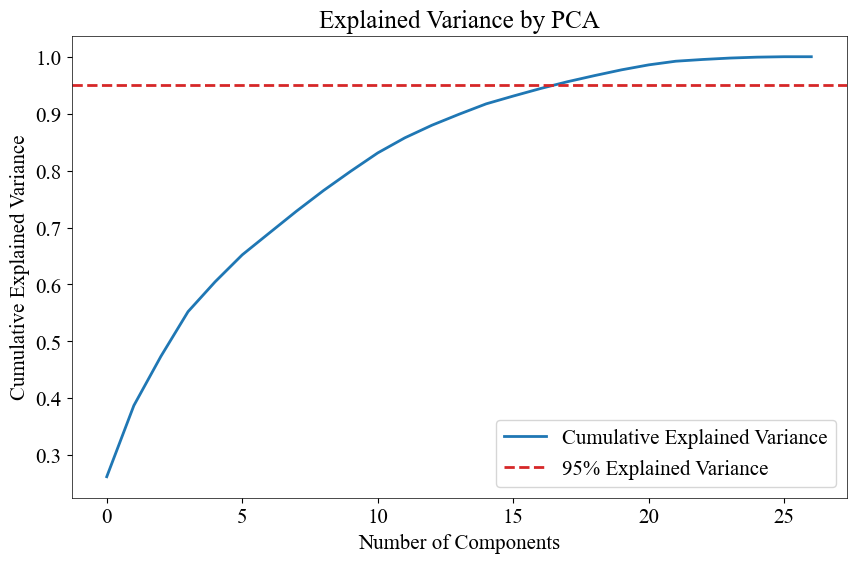

In [ ]:
# train = df.iloc[train_index]

# X_train = train.drop(columns=['% Silica Concentrate'])

# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)

# pca = PCA().fit(X_train_scaled)

# plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Explained Variance', c='tab:blue')
# plt.axhline(0.95, linestyle='--', c='tab:red', label='95% Explained Variance')

# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance by PCA')
# plt.legend(loc=4)

# plt.show()

## 03 - Applying XGBoost Model

In [ ]:
preds = []
scores = []

for ind, (month, group) in enumerate(df.groupby(df.index.month)):
    if ind == 0:
        continue  # Skip the first month
    elif month == 9:
        continue  # Skip September due to insufficient data

    X = group.drop(columns=['% Silica Concentrate'])
    y = group['% Silica Concentrate']

    # Identify the last week of data for testing
    last_week_index = group[group.index >= group.index.max() - pd.Timedelta(days=7)].index

    # Split into training and testing sets
    X_train = X.drop(index=last_week_index)
    y_train = y.drop(index=last_week_index)

    X_test = X.loc[last_week_index]
    y_test = y.loc[last_week_index]

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Principal Component Analysis (PCA)    
    pca = PCA(n_components=0.95)  
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)

    # XGBoost Regressor
    model = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=4,
        early_stopping_rounds=50,
        random_state=42,
        objective='reg:squarederror'
    )

    model.fit(
        X_train_pca, y_train,
        eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)],
        verbose=100
    )

    y_pred = model.predict(X_test_pca)
    preds.append(y_pred)

    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[0]	validation_0-rmse:2.31956	validation_1-rmse:2.26920
[67]	validation_0-rmse:0.75491	validation_1-rmse:1.60280
[0]	validation_0-rmse:2.51041	validation_1-rmse:0.90357
[62]	validation_0-rmse:1.00835	validation_1-rmse:0.88686
[0]	validation_0-rmse:1.66806	validation_1-rmse:1.82955
[100]	validation_0-rmse:0.63879	validation_1-rmse:0.98100
[135]	validation_0-rmse:0.62298	validation_1-rmse:0.99096
[0]	validation_0-rmse:1.62417	validation_1-rmse:2.34804
[100]	validation_0-rmse:0.66616	validation_1-rmse:1.39133
[200]	validation_0-rmse:0.61143	validation_1-rmse:1.38701
[230]	validation_0-rmse:0.60108	validation_1-rmse:1.38780
[0]	validation_0-rmse:1.88459	validation_1-rmse:2.33180
[100]	validation_0-rmse:0.65790	validation_1-rmse:1.26905
[147]	validation_0-rmse:0.61714	validation_1-rmse:1.29280


## 04 - Result Analysis

In [ ]:
print(f'Average RMSE across folds: {np.mean(scores)}')
print(f'RMSE scores for each fold: {scores}')

Average RMSE across folds: 1.0921394884174283
RMSE scores for each fold: [1.3350460556579464, 0.5001585030106976, 0.9780242942071354, 1.379933099247365, 1.267535489963997]


In [ ]:
results = model.evals_result_
print(results.keys())

dict_keys(['validation_0', 'validation_1'])


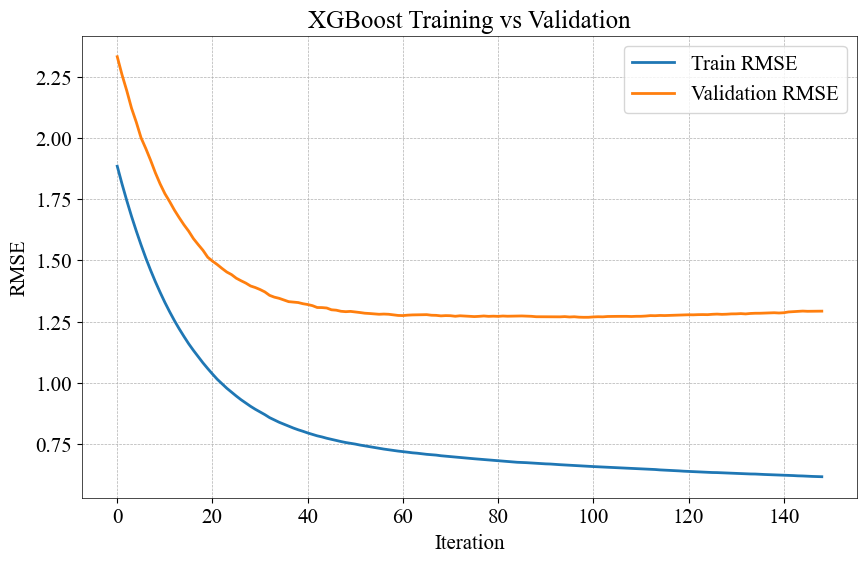

In [ ]:
train_rmse = results['validation_0']['rmse']
val_rmse   = results['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('XGBoost Training vs Validation')
plt.legend()

# plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.3f}')
print(f'R^2 Score: {r2:.3f}')

Mean Absolute Error: 1.010
R^2 Score: -0.027


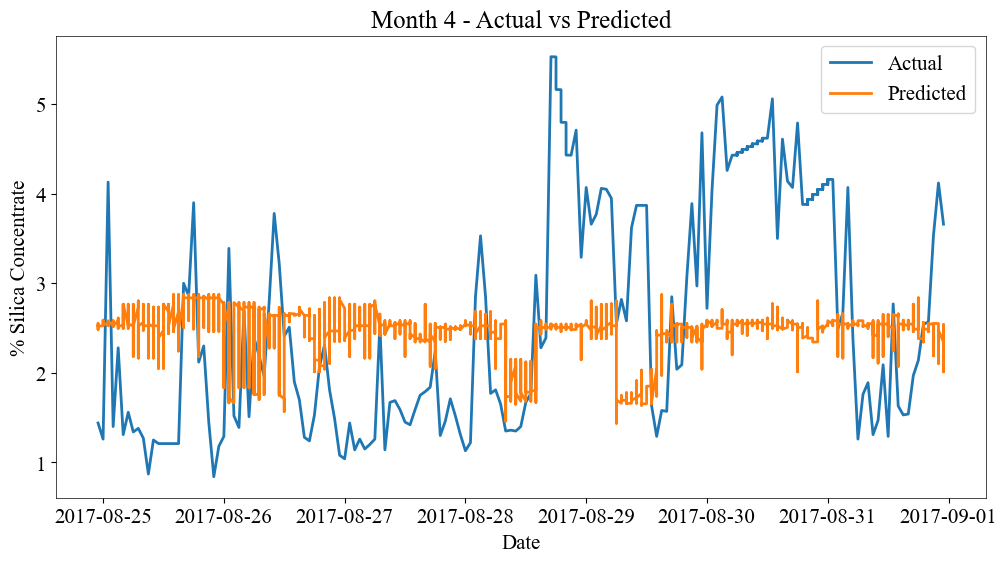

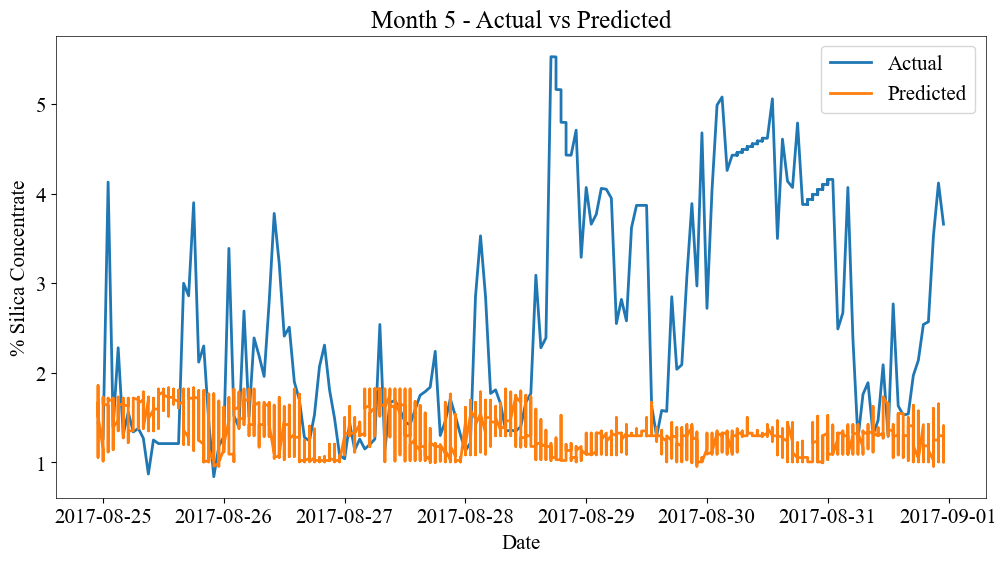

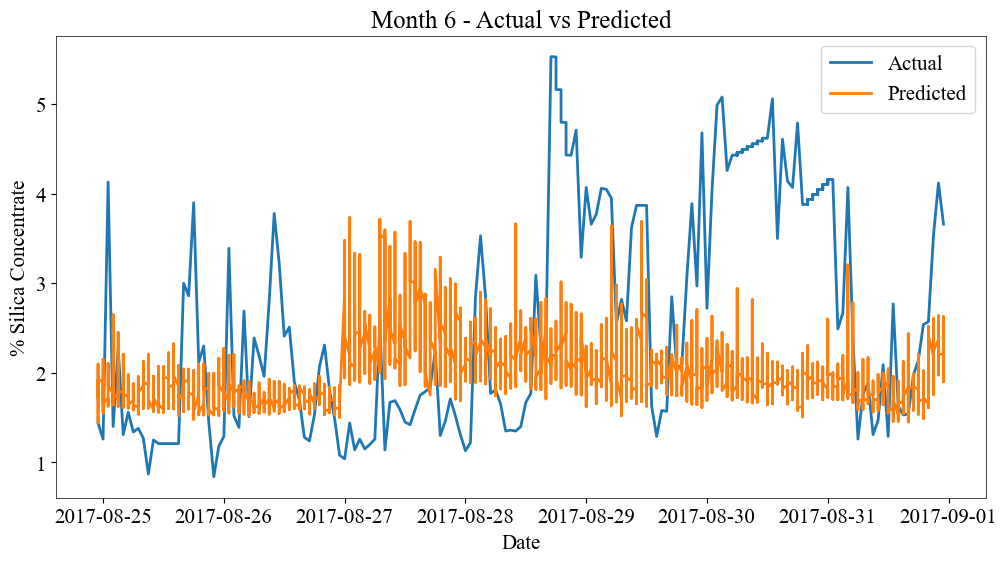

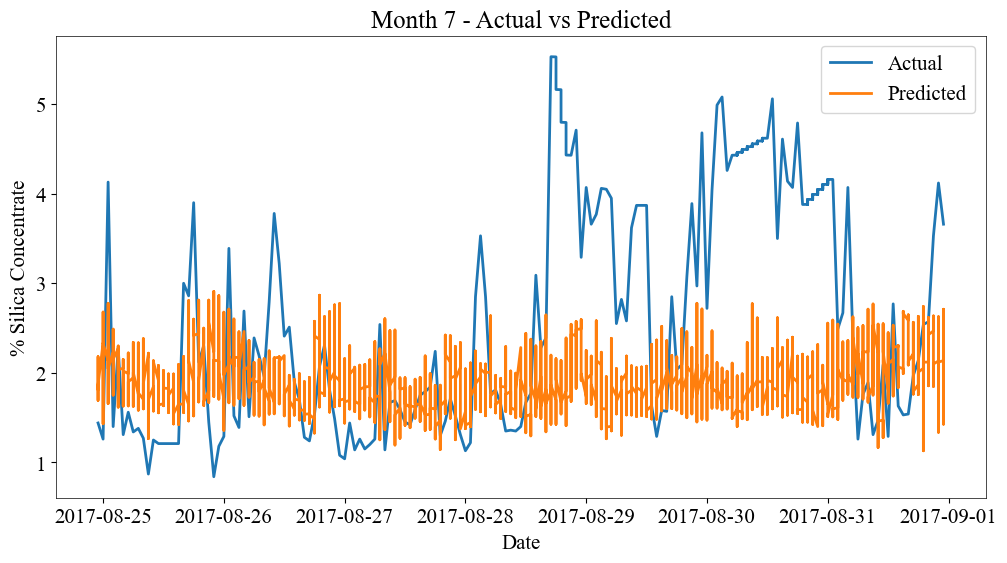

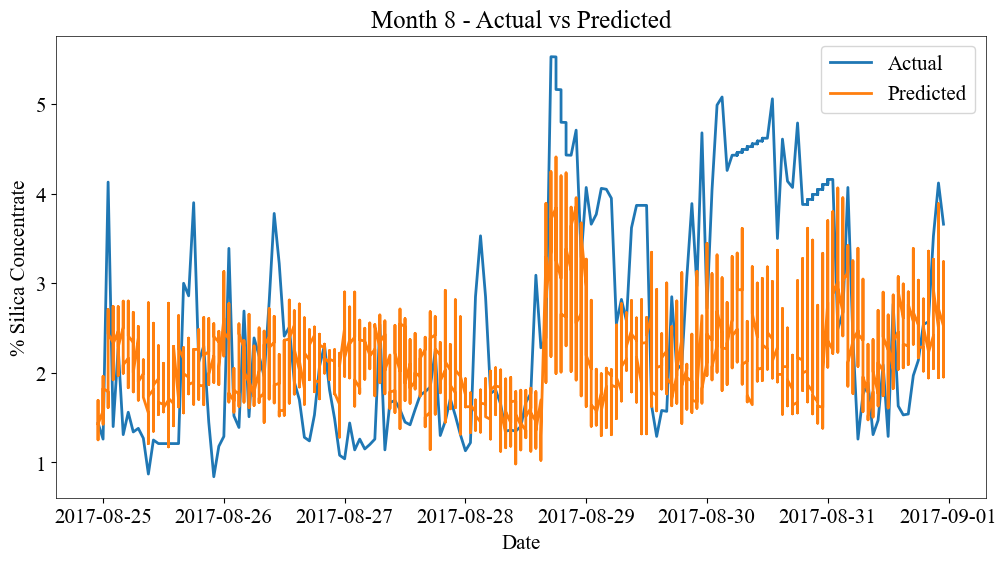

In [44]:
for ind, (month, group) in enumerate(df.groupby(df.index.month)):
    if ind == 0:
        continue  # Skip the first month
    elif month == 9:
        continue  # Skip September due to insufficient data

    plt.figure(figsize=(12, 6))

    plt.plot(y_test.index, y_test, label='Actual', c='tab:blue')
    plt.plot(y_test.index, preds[ind - 1], label='Predicted', c='tab:orange')   

    plt.title(f'Month {month} - Actual vs Predicted')
    plt.ylabel('% Silica Concentrate')
    plt.xlabel('Date')
    plt.legend(loc='upper right')

plt.show()